## Building the Model

We have come up with the following initial architecture: $h^1$ = 500, $h^2$ = 600, $mu$ (learning rate) = 0.01, batch size = 32, activation function = ReLU. The neural network code is provided in [neuralnetwork.py](neuralnetwork.py) with accompanying utility functions in [utils.py](utils.py)


The resulting number of parameters (including the biases) is 699110. It can be calculated by the applying the following formula to each layer: $(n\_inputs + 1) * neuron\_count$ and then summing it up. The $+1$ in the equation accounts for the biases.

### Initialization

The three weight initializations are performed by the following snippet:

```python
    def initialize_weights(self, i, j):
        """
        Initialize the weight matrix i x j for the layer of n entries
        :param i: number of rows of the matrix W (output of the layer)
        :param j: number of columns (input to the layer)
        :return: two-dimensional numpy array
        """
        if self.weight_init == 'zeros':
            weights = np.zeros((i, j))
        elif self.weight_init == 'normal':
            weights = np.array(np.random.normal(0, 1, (i, j)))
        elif self.weight_init == 'glorot':
            d = np.sqrt(6 / (i + j))
            weights = np.random.uniform(-d, d, (i, j))
        else:
            raise RuntimeError('Have not found initializing method for ', self.weight_init)
        return weights
```
Having trained neural networks with three different weight initializions (code snippet below), we save the results in a csv file wich is then read out and plotted. 

zeros 
 [0.90136 0.88644 0.88644 0.88644 0.88644 0.88644 0.88644 0.88644 0.88644
 0.88644]
normal 
 [0.85996 0.0602  0.03438 0.0249  0.01802 0.01188 0.0062  0.0062  0.00404
 0.0027 ]
glorot 
 [0.91968 0.0909  0.07462 0.06214 0.0546  0.04844 0.04714 0.038   0.03532
 0.0314 ]


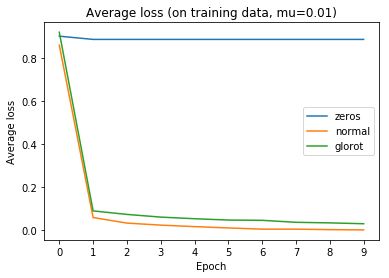

In [17]:
from matplotlib import pyplot as plt
import numpy as np

reports = [('zeros', 'report_epochs=10,hidden_dims=[500,600],mu=0.01,batch_size=32,weight_init=zeros.csv'),
           ('normal', 'report_epochs=10,hidden_dims=[500,600],mu=0.01,batch_size=32,weight_init=normal.csv'),
           ('glorot', 'report_epochs=10,hidden_dims=[500,600],mu=0.01,batch_size=32,weight_init=glorot.csv')
]

for report in reports:
    weight_init, file_name = report
    with open("reports/weight_inits/{}".format(file_name), "r") as f:
        stats = np.loadtxt(f, delimiter=",", skiprows=1)
        train = stats[:, 1]
        print(weight_init, '\n', train)
        plt.plot(train, label=weight_init)
plt.xticks(range(len(train)))
plt.legend()
plt.title('Average loss (on training data, mu=0.01)')
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.show()

**Zero initialization**. As can be seen, initializing weights with zeros results in virtually no learning as depicted by an almost flat learning curve. This can be explained by the backpropagation algorithm. 

On the forward pass all the activations (ReLUs in our case) output zeros and being multiplied by the zero weights result in zero logits. The softmax function then assigns equal probability to each prediction being 0.1 (as there are 10 classes). On the backprop the only the biases of the third layer $b^{(3)}$ have a nonzero gradient, all other parameters, including biases at other layers, are zero. 

This is because the partial derivative of the of the loss $L$ with respect to bias $b^{(k)}_i$ at layer $k$ is equal to $\frac{\partial}{\partial b^{(k)}_i} -log f(x)_y=\frac{\partial -log f(x)_y}{\partial a^{(k)}(x)_i}$. Since the preactivation at the third layer is $\frac{\partial}{\partial a^{(L+1)}(x)_c}-log f(x)_y = f(x)_c - 1_{(y=c)}$ we have nonzero derivative values at the preactivation of the output layer and therefore nonzero values for the bias at the output layer. All the other parameter values are zero because the ReLUs output zeros for the zero inputs. 


**Normal and Glorot initialization**. We observe that the learning curves for the both initialization strategies exhibit similar behavior. However, the weight values under the 'normal' initialization are higher then those under glorot which affects the learning rate. For instance, though we have seen that the normal has a better training performance when $mu$ is at $0.01$, if we change it to $0.1$ the network does not train anymore because of the numerical overflow. The same learning rate of $0.1$ for glorot actually reduces the avarage loss much quicker as can be seen in the figure below.

normal 
 [0.91358 0.88644 0.88644 0.88644 0.88644 0.88644 0.88644 0.8965  0.88644
 0.88644]
glorot 
 [8.979e-01 3.880e-02 1.904e-02 1.736e-02 9.480e-03 6.020e-03 5.660e-03
 6.220e-03 1.760e-03 7.800e-04]


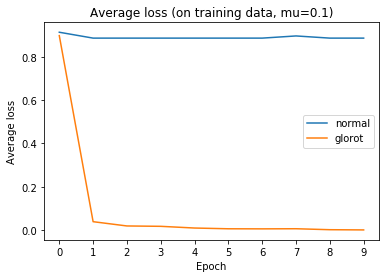

In [19]:
from matplotlib import pyplot as plt
import numpy as np

reports = [
           ('normal', 'report_epochs=10,hidden_dims=[500,600],mu=0.1,batch_size=32,weight_init=normal.csv'),
           ('glorot', 'report_epochs=10,hidden_dims=[500,600],mu=0.1,batch_size=32,weight_init=glorot.csv')
]

for report in reports:
    weight_init, file_name = report
    with open("reports/weight_inits/{}".format(file_name), "r") as f:
        stats = np.loadtxt(f, delimiter=",", skiprows=1)
        train = stats[:, 1]
        print(weight_init, '\n', train)
        plt.plot(train, label=weight_init)
plt.xticks(range(len(train)))
plt.legend()
plt.title('Average loss (on training data, mu=0.1)')
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.show()

### Hyperparameter Search

We use random search to find the best hyperparameters. For that we first define a range of combinations of valid hyperparameters as in

In [15]:
# using log-scale for the learning rate: http://cs231n.github.io/neural-networks-3/#hyper
mus = [10 ** np.random.uniform(-6, 1) for _ in range(0, 5)] 
neurons = [[500, 600], [500, 500], [600, 700], [700, 500]]
combinations = [(mu, neuron) for mu in mus for neuron in neurons]
print('possible combinations:\n', combinations)

possible combinations:
 [(4.614313552623348e-05, [500, 600]), (4.614313552623348e-05, [500, 500]), (4.614313552623348e-05, [600, 700]), (4.614313552623348e-05, [700, 500]), (0.1468423686421048, [500, 600]), (0.1468423686421048, [500, 500]), (0.1468423686421048, [600, 700]), (0.1468423686421048, [700, 500]), (0.3112553202446868, [500, 600]), (0.3112553202446868, [500, 500]), (0.3112553202446868, [600, 700]), (0.3112553202446868, [700, 500]), (4.311580209552355e-06, [500, 600]), (4.311580209552355e-06, [500, 500]), (4.311580209552355e-06, [600, 700]), (4.311580209552355e-06, [700, 500]), (0.013249755451138266, [500, 600]), (0.013249755451138266, [500, 500]), (0.013249755451138266, [600, 700]), (0.013249755451138266, [700, 500])]


hidden_dims=[600,700],mu=4.311580209552355e-06 
 17.199999999999992
hidden_dims=[500,600],mu=0.3112553202446868 
 97.63
hidden_dims=[600,700],mu=4.614313552623348e-05 
 70.23
hidden_dims=[700,500],mu=0.1468423686421048 
 98.28
hidden_dims=[700,500],mu=0.013249755451138266 
 97.11
hidden_dims=[600,700],mu=0.013249755451138266 
 97.11
hidden_dims=[700,500],mu=4.311580209552355e-06 
 22.76
hidden_dims=[600,700],mu=0.3112553202446868 
 98.21
hidden_dims=[700,500],mu=0.3112553202446868 
 98.38
hidden_dims=[500,500],mu=4.614313552623348e-05 
 64.49000000000001
Best model with params  hidden_dims=[700,500],mu=0.3112553202446868  has accuracy of  98.38


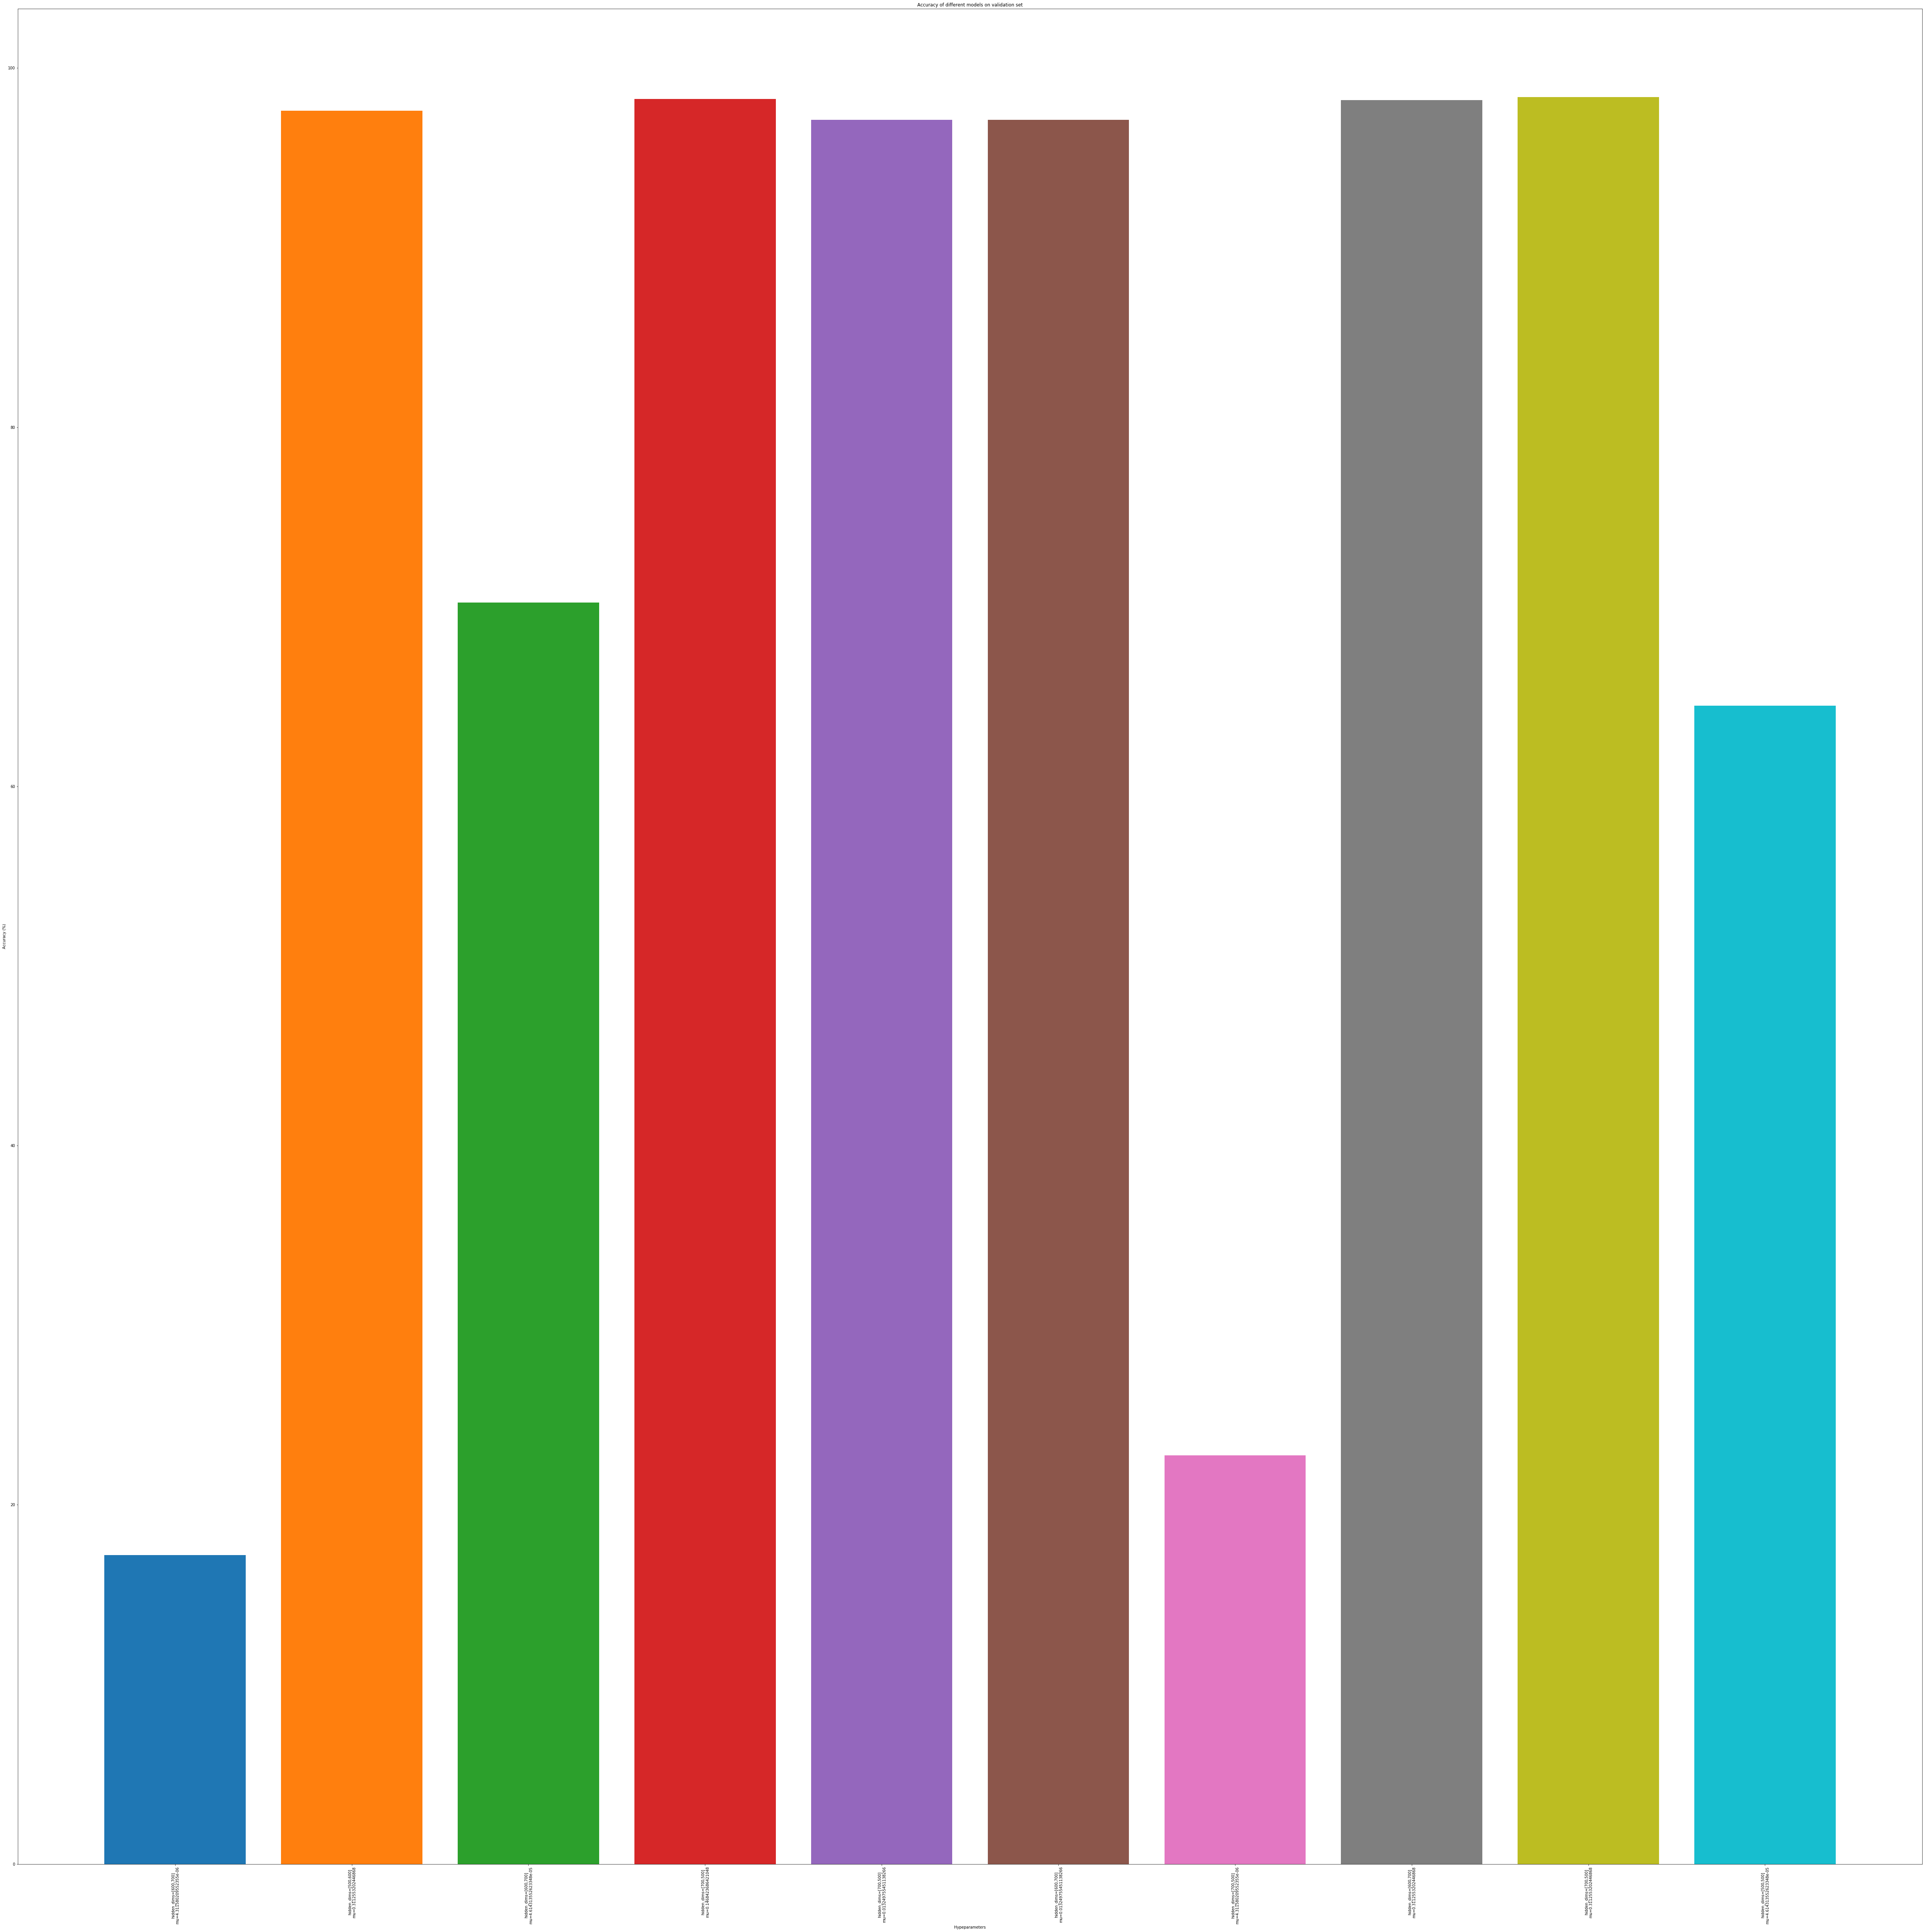

In [42]:
from matplotlib import pyplot as plt
import numpy as np
import os

reports = [f.replace('.csv', '') for f in os.listdir("reports/hyperparams")]

best_model = None
y_pos = np.arange(len(reports))
for idx, hp in enumerate(reports):
    with open("reports/hyperparams/{}.csv".format(hp), "r") as f:
        stats = np.loadtxt(f, delimiter=",", skiprows=1)
        accuracy = (1 - stats[-1, 3]) * 100
        print(hp, '\n', accuracy)
        if best_model is None or best_model[1] < accuracy:
            best_model = (hp, accuracy)
        plt.bar(idx, accuracy, label=hp)

print('Best model with params ', best_model[0], ' has accuracy of ', best_model[1])
plt.xticks(y_pos, [r.replace(',m','\nm') for r in reports], rotation=90)
plt.title('Accuracy of different models on validation set')
plt.xlabel('Hypeparameters')
plt.ylabel('Accuracy (%)')
plt.show()